<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
#!pip install -q shap
#!pip install -q phik

In [2]:
import pandas as pd
import phik
import shap
import seaborn as sns
import numpy as np


import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Подготовка

In [3]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [4]:
display(df.sample(10))

,num_orders
datetime,
2018-08-27 10:20:00,32
2018-08-10 15:10:00,9
2018-07-23 21:10:00,18
2018-06-26 14:20:00,13
2018-03-28 05:50:00,2
2018-06-06 06:20:00,3
2018-06-02 23:00:00,9
2018-03-07 07:00:00,2
2018-05-01 12:30:00,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков нет, явно аномальных значений нет. 26496 значений в изначальной таблице.

## Анализ

Ресемплируем по часам:

In [7]:
df.sort_index(inplace=True)
df_day = df.resample('1D').sum()
df = df.resample('1H').sum()

Скользящее среднее:

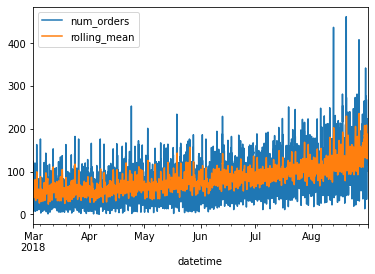

In [8]:
df['rolling_mean'] = df.rolling(8).mean() 
df.plot();

In [9]:
print("Первые 8 строк:")
display(df.head(8))
print("\nВторые 8 строк:")
display(df.iloc[8:16])
print("\nТретьи 8 строк:")
display(df.iloc[16:24])

Первые 8 строк:


,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,NaN
2018-03-01 07:00:00,15,52.75



Вторые 8 строк:


,num_orders,rolling_mean
datetime,,
2018-03-01 08:00:00,34,41.500
2018-03-01 09:00:00,69,39.500
2018-03-01 10:00:00,64,38.625
2018-03-01 11:00:00,96,42.375
2018-03-01 12:00:00,30,40.750
2018-03-01 13:00:00,32,44.000
2018-03-01 14:00:00,48,48.500
2018-03-01 15:00:00,66,54.875



Третьи 8 строк:


,num_orders,rolling_mean
datetime,,
2018-03-01 16:00:00,43,56.000
2018-03-01 17:00:00,44,52.875
2018-03-01 18:00:00,73,54.000
2018-03-01 19:00:00,45,47.625
2018-03-01 20:00:00,61,51.500
2018-03-01 21:00:00,66,55.750
2018-03-01 22:00:00,113,63.875
2018-03-01 23:00:00,58,62.875


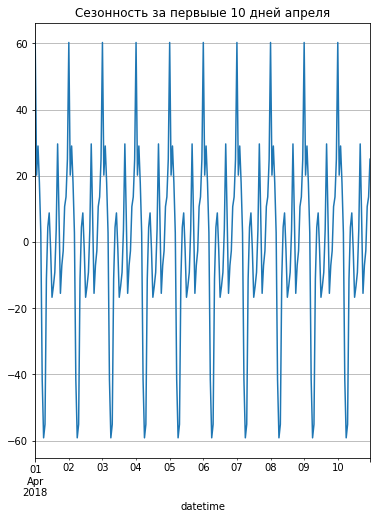

In [10]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
decomposed.seasonal['2018-04-01':'2018-04-10'].plot(ax=plt.gca())
plt.title('Сезонность за первыые 10 дней апреля')
plt.grid(True)
plt.show()

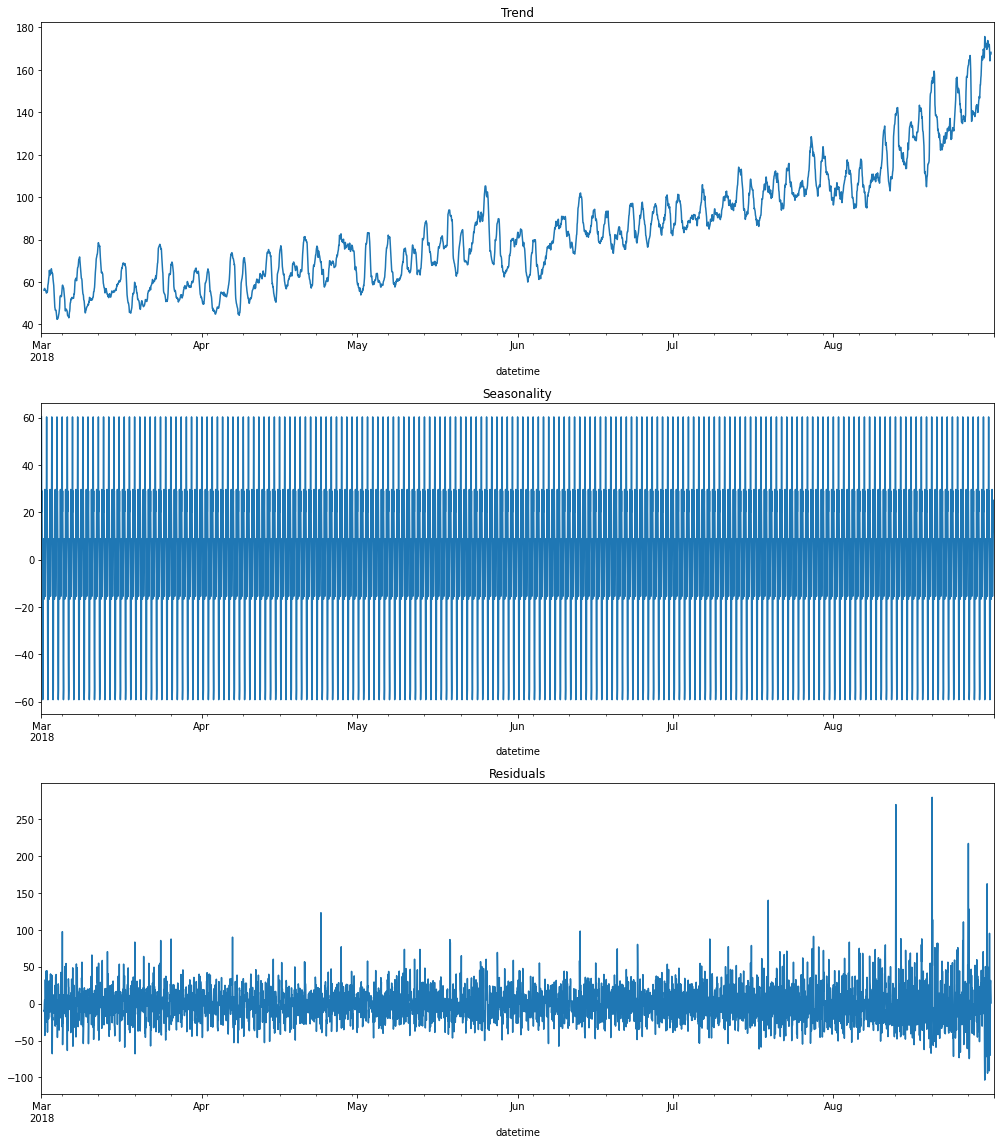

In [11]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(14, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

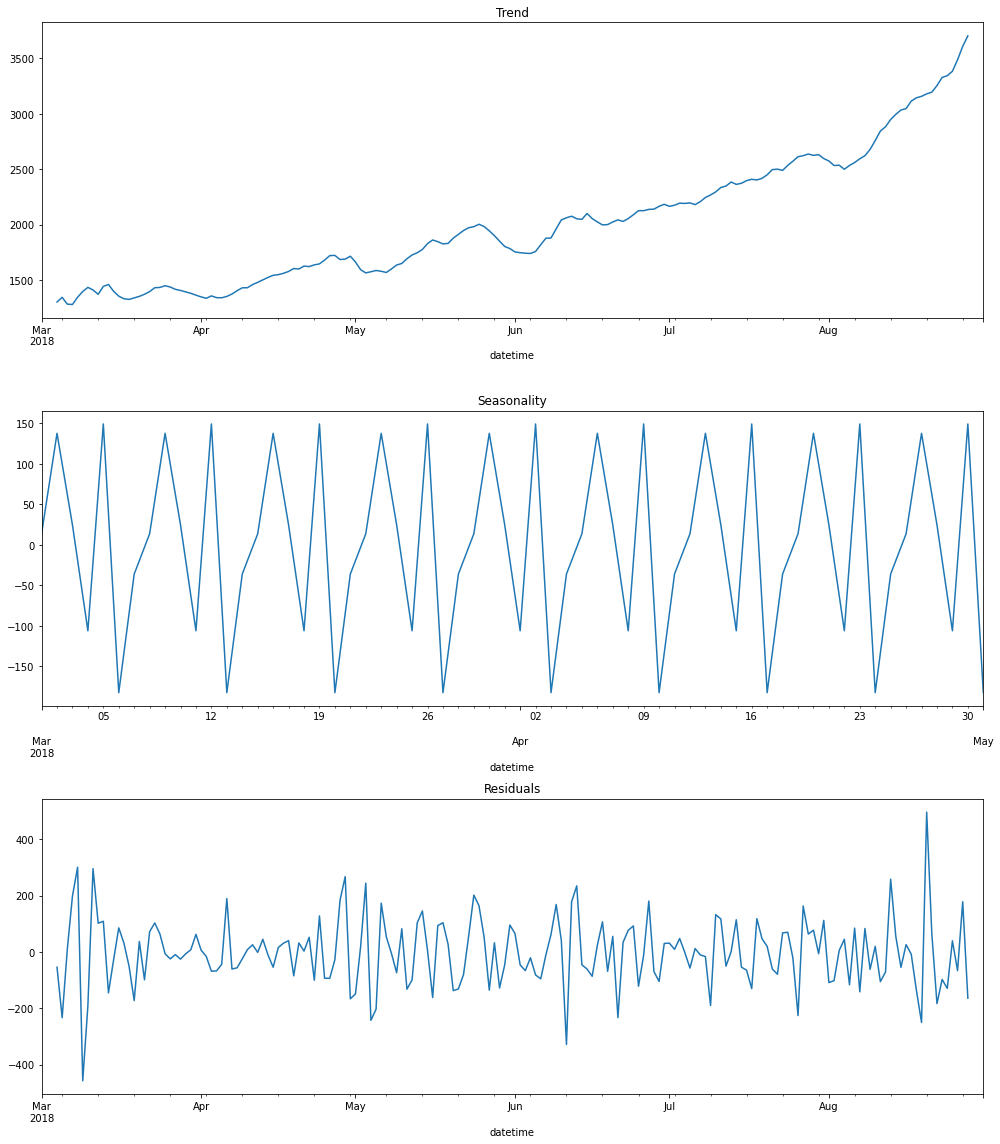

In [12]:
decomposed = seasonal_decompose(df_day['num_orders'])

plt.figure(figsize=(14, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01': '2018-05-01'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Наблюдается восходящий тренд. Сезонность распределена по суткам, период и амплитуда постоянные. В остатках ближе к концу усиливается разброс.


Функция для создания признаков:

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(max_lag):
        data[f'lag_{i+1}'] = data['num_orders'].shift(i+1)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    hour = data.index.hour
              
    return data

In [14]:
df_features = make_features(df, 24, 168)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


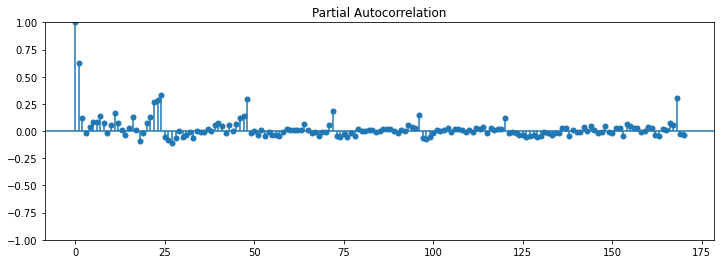

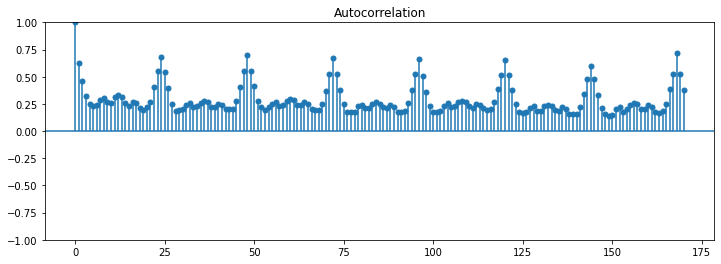

In [15]:
plot_pacf(df['num_orders'], alpha=None, lags=170).set_size_inches(12, 4)
plt.show()

plot_acf(df['num_orders'], alpha=None, lags=170).set_size_inches(12, 4)
plt.show()

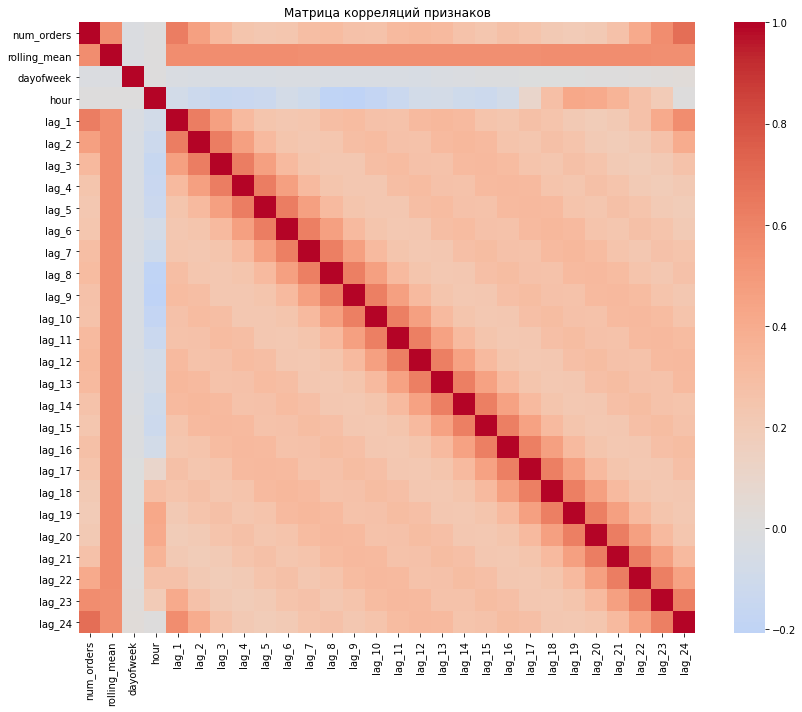

In [16]:
corr = df_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

Разностные признаки коррелируют между собой, особенно ближние.

Я добавлял в модель признак "сезон" (лето, зима и тд) и признак "час-пик". Сезонность скорее навредила, потому что данные ограничены 8 месяцами и в выборках разбиты последовательно. Час-пик совершенно не влияют на модель по *Shap*-анализу. 

## Обучение

In [17]:
df_features = df_features.dropna()

In [18]:
X = df_features.drop('num_orders', axis=1)
y = df_features['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=1)

In [19]:
num_cols = X_train.select_dtypes(include='number').columns.tolist()

In [20]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', 'passthrough')
])

params = [
    {  # LinearRegression
        'model': [LinearRegression()],
        'scaler': [StandardScaler(), 'passthrough']
    },
    {  # CatBoost
        'model': [CatBoostRegressor(verbose=False, random_state=1)],
        'model__iterations': [100, 200,250, 300],
        'model__depth': [4, 6, 8, 10],
        'model__learning_rate': [0.04, 0.05, 0.06],
        'scaler': ['passthrough']
    },
    {  # LGBM
        'model': [LGBMRegressor(random_state=1, verbose=-1)],
        'model__n_estimators': [100, 200, 300],
        'model__num_leaves': [31, 65, 127],
        'scaler': ['passthrough']
    }
]

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    pipe,
    params,
    n_iter=15,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=1,
    n_jobs=-1,
    verbose=1
)


In [21]:
search.fit(X_train, y_train)

print('Лучшие параметры:', search.best_params_)
print('Лучшая модель:', type(search.best_estimator_.named_steps['model']).__name__)

y_pred = search.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Лучшая RMSE: {rmse:.4f}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшие параметры: {'scaler': 'passthrough', 'model__learning_rate': 0.06, 'model__iterations': 200, 'model__depth': 6, 'model': <catboost.core.CatBoostRegressor object at 0x7fb86050fca0>}
Лучшая модель: CatBoostRegressor
Лучшая RMSE: 44.1139


In [22]:
model = ARIMA(y_train, order=(2, 1, 2))
model_fit = model.fit()

y_pred = model_fit.forecast(steps=len(y_test))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'ARIMA RMSE: {rmse:.4f}')

ARIMA RMSE: 64.3233


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit()

y_pred = model_fit.forecast(steps=len(y_test))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75902D+00    |proj g|=  3.90962D-01

At iterate    5    f=  4.67456D+00    |proj g|=  9.40168D-02

At iterate   10    f=  4.62280D+00    |proj g|=  3.61158D-01

At iterate   15    f=  4.61614D+00    |proj g|=  2.47978D-02

At iterate   20    f=  4.61211D+00    |proj g|=  7.53146D-02

At iterate   25    f=  4.53975D+00    |proj g|=  1.63607D-01

At iterate   30    f=  4.50005D+00    |proj g|=  4.84135D-02

At iterate   35    f=  4.49876D+00    |proj g|=  3.84646D-03

At iterate   40    f=  4.49787D+00    |proj g|=  1.73473D-01

At iterate   45    f=  4.49106D+00    |proj g|=  8.11029D-01

At iterate   50    f=  4.48692D+00    |proj g|=  4.78659D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'SARIMA RMSE: {rmse:.4f}')

SARIMA RMSE: 44.3431


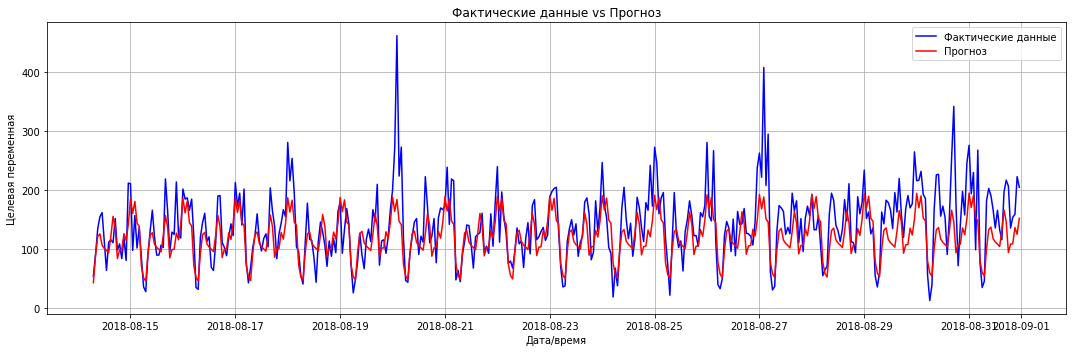

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Фактические данные', color='blue')
plt.plot(y_test.index, y_pred, label='Прогноз', color='red')
plt.title('Фактические данные vs Прогноз')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Тестирование

In [26]:
print('Среднее количество заказов в час:', y_test.mean())

pred_median = np.ones(y_train.shape)*y_train.median()
dummy_rmse = mean_squared_error(y_train, pred_median, squared=False)

print(f'RMSE: {dummy_rmse:.4f}')

Среднее количество заказов в час: 140.08705882352942
RMSE: 39.0091


In [30]:
print('Среднее количество заказов в час:', y_test.mean())

pred_previous = y_train.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
dummy_rmse = mean_squared_error(y_train, pred_previous, squared=False)

print(f'RMSE: {dummy_rmse:.4f}')

Среднее количество заказов в час: 140.08705882352942
RMSE: 36.5200


Лучшая модель показала себя лучше заглушек

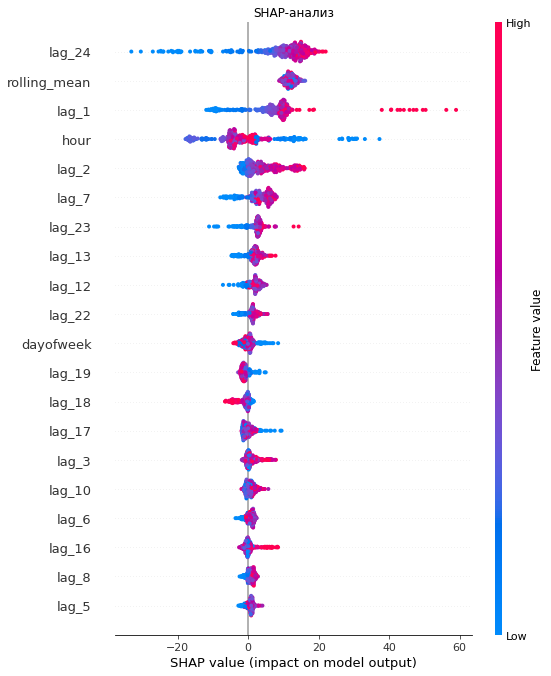

In [28]:
best_pipeline = search.best_estimator_
model = best_pipeline.named_steps['model']
X_transformed = X_test.copy()

X_transformed_df = pd.DataFrame(X_transformed, columns=X_test.columns)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_transformed_df)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed_df, feature_names=X_test.columns, show=False)
plt.title('SHAP-анализ')
plt.tight_layout()
plt.show()

    1. `rolling_mean` - Узкое распределение, оказывает положительное влияние на предсказание.
    2. `lag_24` - Широкое распределение, но меньше влияет на повышение предсказания.
    3. `hour` - Положительные значения "обнуляют модель", отрицательные могут как повышать, так и понижать.

## Выводы


1. Пропусков нет, явно аномальных значений нет. 26496 значений в изначальной таблице.<br><br>
2. Наблюдается восходящий тренд. Сезонность распределена по суткам, период и амплитуда постоянные. В остатках ближе к концу усиливается разброс.
   Разностные признаки коррелируют между собой, особенно ближние.   
   В модель были добавлены два дополнительных признака: "сезон" (лето, зима и тд), "час-пик". Сезонность скорее навредила, потому что данные ограничены 8 месяцами и в выборках разбиты последовательно. Час-пик совершенно не повлияюл на модель согласно *Shap*-анализу. <br><br>
3. Лучшая модель: *CatBoostRegressor*, Лучшая *RMSE*: 44.1139. Модель показала себя лучше заглушек.<br><br>
4. Анализ признаков:  
    1. `rolling_mean` - Узкое распределение, оказывает положительное влияние на предсказание.
    2. `lag_24` - Широкое распределение, но меньше влияет на повышение предсказания.
    3. `hour` - Положительные значения "обнуляют модель", отрицательные могут как повышать, так и понижать.